In [1]:
# --- Blok 0: imports & globale config ---
from __future__ import annotations
from pathlib import Path
import json, functools, random, os
import numpy as np
import pandas as pd
import soundfile as sf
import librosa, librosa.display
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Dataset-root en labels
DATA_ROOT = Path("../data").resolve()
TASKS = ["coughing", "heartsounds"]
MICS  = ["new_microphone", "old_microphone"]

# Segment & audio-constanten
SEG_DUR = 3.0       # s
SR_FIXED = 15750    # Hz (volgens sidecar .json)

# STFT-parameters (consistent met EDA)
N_FFT = 1024
HOP   = 256
WIN   = "hann"

# Afgeleide vormen
F_BINS = 1 + N_FFT // 2
T_TARGET = librosa.time_to_frames(SEG_DUR, sr=SR_FIXED, hop_length=HOP, n_fft=N_FFT)  # vaste breedte

# Model-output map
MODEL_DIR = Path("./models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# --- Blok B: scan .wav + .json en bouw dataframes ---

def find_wavs_and_jsons(root: Path) -> pd.DataFrame:
    """
    Return a DataFrame with one row per .wav.
    Columns: path, relpath, task, mic, json_path
    """
    rows = []
    for task in TASKS:
        for mic in MICS:
            base = root / task / mic
            if not base.is_dir():
                continue
            for wav in sorted(base.rglob("*.wav")):
                js = wav.with_suffix(".json")
                rows.append({
                    "path": str(wav.resolve()),
                    "relpath": str(wav.relative_to(root).as_posix()),
                    "task": task,
                    "mic": mic,
                    "json_path": str(js.resolve()) if js.exists() else None,
                })
    df = pd.DataFrame(rows).sort_values(["task","mic","relpath"]).reset_index(drop=True)
    return df

def read_segments_from_json(json_path: Path) -> list[dict]:
    """
    Read segments from sidecar .json (format from your example).
    Returns list of dicts: seg_id, t_start, t_end, dur, labels(list[str])
    """
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    segs = d.get("segments", [])
    out = []
    for s in segs:
        t0 = float(s["t_start"]); t1 = float(s["t_end"])
        out.append({
            "seg_id": s["id"],
            "t_start": t0,
            "t_end": t1,
            "dur": t1 - t0,
            "labels": list(s.get("labels", [])),
        })
    return out

def build_segments_table(df_files: pd.DataFrame) -> pd.DataFrame:
    """
    Build a table with one row per segment.
    Columns: path, relpath, task, mic, seg_id, t_start, t_end, dur, labels
    """
    rows = []
    for _, r in df_files.iterrows():
        if r["json_path"] is None:
            continue
        segs = read_segments_from_json(Path(r["json_path"]))
        for s in segs:
            rows.append({
                "path": r["path"],
                "relpath": r["relpath"],
                "task": r["task"],
                "mic": r["mic"],
                "seg_id": s["seg_id"],
                "t_start": s["t_start"],
                "t_end": s["t_end"],
                "dur": s["dur"],
                "labels": s["labels"],
            })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["task","mic","relpath","t_start"]).reset_index(drop=True)
    return df

In [3]:
# Inladen
df_files = find_wavs_and_jsons(DATA_ROOT)
print(f"Aantal .wav-bestanden: {len(df_files)}")
display(df_files.head(5))

Aantal .wav-bestanden: 40


,path,relpath,task,mic,json_path
0,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...
1,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_2.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...
2,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_3.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...
3,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_4.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...
4,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_5.wav,coughing,new_microphone,C:\Users\MSI\Documents\Persoonlijke Projecten\...


In [4]:
df_segs  = build_segments_table(df_files)
print(f"Aantal segmenten: {len(df_segs)}")
display(df_segs.head(5))

Aantal segmenten: 369


,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
0,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,dae77b6c-e8e4-43cc-baaf-b56cf1bd01ef,1.68,4.68,3.0,[Hoest]
1,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,de8a067b-e2d6-4660-8589-189294866f25,6.80,9.80,3.0,[Hoest]
2,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,9d213259-75ac-428e-83e2-10dbe74a88e3,11.93,14.93,3.0,[Hoest]
3,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,c2b67ec8-0263-4b8a-be39-088835a9678f,16.77,19.77,3.0,[Hoest]
4,C:\Users\MSI\Documents\Persoonlijke Projecten\...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,e712c1eb-c012-4b39-bf22-b9c94126352d,21.38,24.38,3.0,[Hoest]


In [5]:
# --- Blok 1: audio & spectrogram helpers ---
import functools
import numpy as np
import soundfile as sf
from scipy import signal
import librosa

SEG_DUR = 3.0
N_FFT = 1024
HOP   = 256
WIN   = "hann"

@functools.lru_cache(maxsize=2048)
def load_audio_cached(wav_path: str):
    """Load mono audio and sample rate."""
    y, sr = sf.read(wav_path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    return y.astype(np.float32), int(sr)

def slice_seconds(y: np.ndarray, sr: int, t0: float, t1: float) -> np.ndarray:
    """Return y[t0:t1] in seconds, clamped."""
    a = max(0, int(round(t0 * sr)))
    b = min(len(y), int(round(t1 * sr)))
    return y[a:b]

# Bandpass-profielen (ruimer/taakafhankelijk)
BAND_COUGH   = (80.0, 3000.0)   # Normaal vs Hoest
BAND_HEART   = (20.0, 600.0)    # alles met Hart
BAND_DEFAULT = (30.0, 3000.0)

def bandpass_filter(y: np.ndarray, fs: int, fc=(30.0, 3000.0), order=4, zero_phase=True) -> np.ndarray:
    """Butterworth bandpass; zero-phase standaard."""
    low, high = fc
    high = min(high, fs/2 - 1.0)
    sos = signal.butter(order, [low, high], btype="bandpass", fs=fs, output="sos")
    return (signal.sosfiltfilt(sos, y) if zero_phase else signal.sosfilt(sos, y)).astype(np.float32)

def stft_db_fixed(y: np.ndarray, sr: int, n_fft=N_FFT, hop_length=HOP, win=WIN, t_target=None) -> np.ndarray:
    """
    |STFT| -> dB, tijd-as gefixt naar vaste breedte.
    Clip naar [-80,0] dB en schaal naar [0,1] (energie-informatie blijft behouden).
    Output: (F, T)
    """
    if t_target is None:
        t_target = librosa.time_to_frames(SEG_DUR, sr=sr, hop_length=hop_length, n_fft=n_fft)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=win, center=True)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=1.0)
    S_db = librosa.util.fix_length(S_db, size=int(t_target), axis=1)
    S_db = np.clip(S_db, -80.0, 0.0)
    S_img = (S_db + 80.0) / 80.0
    return S_img.astype(np.float32)

def augment_wave(y: np.ndarray, sr: int, p=0.5) -> np.ndarray:
    """Kleine tijdshift + gain + licht ruisje (alleen voor training)."""
    if np.random.rand() > p:
        return y
    shift = np.random.randint(-int(0.05*sr), int(0.05*sr))
    y = np.roll(y, shift)
    gain = 10**(np.random.uniform(-2, 2)/20.0)
    y = y * gain
    noise = np.random.normal(0, 0.005*np.maximum(1.0, y.std()), size=len(y)).astype(np.float32)
    return (y + noise).astype(np.float32)


In [6]:
# --- Blok 2: label mapping naar {Normaal, Hoest, Hart} ---

def map_class_tag(row: pd.Series) -> str:
    """
    Define 3-class tag:
    - 'Hart'  : all segments from heartsounds/
    - 'Hoest' : segments from coughing/ that contain label 'Hoest'
    - 'Normaal': segments from coughing/ without 'Hoest' (e.g., 'Normaal')
    """
    if row["task"] == "heartsounds":
        return "Hart"
    has_hoest = any(lbl.lower() == "hoest" for lbl in row.get("labels", []))
    return "Hoest" if has_hoest else "Normaal"

df_segs = df_segs.copy()
df_segs["class_tag"] = df_segs.apply(map_class_tag, axis=1)
display(df_segs["class_tag"].value_counts())

def make_binary_subset(df: pd.DataFrame, class_a: str, class_b: str) -> pd.DataFrame:
    """
    Filter df to only two classes (class_a, class_b) and reindex.
    Keeps group info by file to split without leakage.
    """
    sub = df[df["class_tag"].isin([class_a, class_b])].copy().reset_index(drop=True)
    sub["y"] = sub["class_tag"].map({class_a: 0, class_b: 1}).astype(np.int64)
    sub["group"] = sub["relpath"]  # group by file to avoid leakage
    return sub


class_tag
Hart       200
Normaal    115
Hoest       54
Name: count, dtype: int64

In [7]:
# --- Blok A (nieuw): diagnose van splits ---
def check_split_counts(df_train, df_val, df_test, name=""):
    def counts(df):
        vc = df["y"].value_counts().to_dict()
        return {int(k): int(v) for k, v in vc.items()}
    print(f"[{name}] y-train {counts(df_train)} | y-val {counts(df_val)} | y-test {counts(df_test)}")

In [8]:
# --- Blok 3 (vervangen): balanced splits + featurebouw ---
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

SEED = 42

def _try_group_split(df_sub, test_size, val_size, seed):
    gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    idx_trainval, idx_test = next(gss1.split(df_sub, df_sub["y"], groups=df_sub["group"]))
    df_trainval = df_sub.iloc[idx_trainval].reset_index(drop=True)
    df_test     = df_sub.iloc[idx_test].reset_index(drop=True)

    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=seed+1)
    idx_train, idx_val = next(gss2.split(df_trainval, df_trainval["y"], groups=df_trainval["group"]))
    df_train = df_trainval.iloc[idx_train].reset_index(drop=True)
    df_val   = df_trainval.iloc[idx_val].reset_index(drop=True)
    return df_train, df_val, df_test

def balanced_group_split(df_sub, test_size=0.2, val_size=0.1, seed=SEED, max_tries=200):
    """Herhaal splitten tot train/val/test allebei de klassen bevatten."""
    rng = np.random.RandomState(seed)
    for _ in range(max_tries):
        s = int(rng.randint(0, 10_000))
        df_train, df_val, df_test = _try_group_split(df_sub, test_size, val_size, s)
        if df_train["y"].nunique()==2 and df_val["y"].nunique()==2 and df_test["y"].nunique()==2:
            return df_train, df_val, df_test
    raise RuntimeError("Geen gebalanceerde group-split gevonden (dataset te scheef?)")

def rows_to_images(rows, band=(30.0,3000.0), do_aug=False):
    """Zet segment-rijen om naar 4D tensor (N,F,T,1)."""
    X = []
    for _, r in rows.iterrows():
        y, sr = load_audio_cached(r["path"])
        y = slice_seconds(y, sr, r["t_start"], r["t_end"])
        if do_aug:
            y = augment_wave(y, sr)
        y = bandpass_filter(y, sr, fc=band, order=4, zero_phase=True)
        S = stft_db_fixed(y, sr)
        X.append(S[..., None])
    return np.stack(X, axis=0)

def normalize_datasets(X_train, X_val, X_test):
    """Dataset-brede z-score op train; toepassen op val/test."""
    mu = X_train.mean(dtype=np.float64)
    sd = X_train.std(dtype=np.float64) + 1e-8
    X_train = ((X_train - mu) / sd).astype(np.float32)
    X_val   = ((X_val   - mu) / sd).astype(np.float32)
    X_test  = ((X_test  - mu) / sd).astype(np.float32)
    return X_train, X_val, X_test

def build_numpy_sets_balanced(df_sub, band=(30.0,3000.0)):
    """Balanced split per bestand + features + normalisatie + klassengewichten."""
    df_train, df_val, df_test = balanced_group_split(df_sub, test_size=0.2, val_size=0.1, seed=SEED)
    check_split_counts(df_train, df_val, df_test, name="balanced")

    X_train = rows_to_images(df_train, band=band, do_aug=True)
    X_val   = rows_to_images(df_val,   band=band, do_aug=False)
    X_test  = rows_to_images(df_test,  band=band, do_aug=False)

    y_train = df_train["y"].to_numpy(); y_val = df_val["y"].to_numpy(); y_test = df_test["y"].to_numpy()

    X_train, X_val, X_test = normalize_datasets(X_train, X_val, X_test)

    classes = np.array([0,1], dtype=np.int64)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

    input_shape = X_train.shape[1:]  # (F, T, 1)
    return (X_train, y_train, X_val, y_val, X_test, y_test, input_shape, class_weight)

In [10]:
# --- Blok 4: modelbouw, training, evaluatie, export ---

def build_simple_cnn(input_shape, num_classes=2) -> keras.Model:
    """Very small CNN as given."""
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

def evaluate_and_plot(model: keras.Model, X, y, title: str, class_names=("klasse0","klasse1")):
    """
    Compute accuracy and show a confusion matrix with:
    - axis tick labels that show the numeric label AND the class name (e.g. '0: Normaal')
    - per-cell annotations with counts and row-normalized percentages
    """
    # Predictions
    y_proba = model.predict(X, verbose=0)
    y_pred = y_proba.argmax(axis=1)

    # Metrics
    acc = accuracy_score(y, y_pred)
    print(f"{title} — Accuracy: {acc:.3f}")
    print(f"Label mapping: 0 = '{class_names[0]}', 1 = '{class_names[1]}'")

    # Confusion matrix (counts) + row-normalized percentages
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_row = np.where(row_sums > 0, cm / row_sums, 0.0)

    # Plot
    fig, ax = plt.subplots(figsize=(3.8, 3.6))
    im = ax.imshow(cm, interpolation="nearest", cmap="viridis")
    ax.set_title(f"{title} — CM")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels([f"0: {class_names[0]}", f"1: {class_names[1]}"])
    ax.set_yticklabels([f"0: {class_names[0]}", f"1: {class_names[1]}"])

    # Annotate counts + percentages
    vmax = cm.max() if cm.size else 1
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            pct = cm_row[i, j]
            ax.text(j, i, f"{count}\n({pct:.0%})",
                    ha="center", va="center",
                    color="white" if count > 0.6 * vmax else "black", fontsize=10)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("count")
    plt.tight_layout(); plt.show()

    return acc, cm, y_pred, y_proba

def export_tflite(model: keras.Model, out_path: Path):
    """Export Keras model to TFLite with dynamic range quantization."""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    out_path.write_bytes(tflite_model)
    print(f"Saved: {out_path.resolve()}")

In [ ]:
# --- Blok 5: runner met taakafhankelijke bandpass + class_weight ---
from tensorflow import keras

def run_experiment(class_a: str, class_b: str, tag: str):
    print(f"\n=== Experiment: {class_a} vs {class_b} ===")
    df_sub = make_binary_subset(df_segs, class_a, class_b)
    print("Aantal segmenten:", len(df_sub), "|", df_sub["class_tag"].value_counts().to_dict())

    if "Hart" in (class_a, class_b):
        band = BAND_HEART
    elif {"Normaal", "Hoest"} == set([class_a, class_b]):
        band = BAND_COUGH
    else:
        band = BAND_DEFAULT

    X_train, y_train, X_val, y_val, X_test, y_test, input_shape, class_weight = \
        build_numpy_sets_balanced(df_sub, band=band)

    print("Shapes:", "\n  train:", X_train.shape, "\n  val  :", X_val.shape, "\n  test :", X_test.shape)

    model = build_simple_cnn(input_shape, num_classes=2)

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=4, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ]

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=32,
        verbose=2,
        callbacks=callbacks,
        class_weight=class_weight,
    )

    evaluate_and_plot(model, X_val,  y_val,  title=f"{tag} — Val",  class_names=(class_a, class_b))
    evaluate_and_plot(model, X_test, y_test, title=f"{tag} — Test", class_names=(class_a, class_b))

    out_tflite = MODEL_DIR / f"cnn_{tag}.tflite"
    export_tflite(model, out_tflite)

    # NIEUW: stats voor manifest
    mu = float(X_train.mean(dtype=np.float64))
    sd = float(X_train.std(dtype=np.float64) + 1e-8)

    stats = {
        "input_shape": tuple(map(int, input_shape)),  # (F,T,1)
        "mean": mu,
        "std": sd,
        "band": band
    }
    return model, stats


=== Experiment: Normaal vs Hart ===
Aantal segmenten: 315 | {'Hart': 200, 'Normaal': 115}
[balanced] y-train {1: 140, 0: 81} | y-val {1: 20, 0: 10} | y-test {1: 40, 0: 24}
Shapes: 
  train: (221, 513, 182, 1) 
  val  : (30, 513, 182, 1) 
  test : (64, 513, 182, 1)
Epoch 1/40
7/7 - 5s - loss: 26.3937 - accuracy: 0.5249 - val_loss: 12.7429 - val_accuracy: 0.3333 - lr: 0.0010 - 5s/epoch - 707ms/step
Epoch 2/40
7/7 - 4s - loss: 8.9278 - accuracy: 0.5204 - val_loss: 1.0681 - val_accuracy: 0.6667 - lr: 0.0010 - 4s/epoch - 613ms/step
Epoch 3/40
7/7 - 4s - loss: 0.9182 - accuracy: 0.6380 - val_loss: 0.7381 - val_accuracy: 0.5667 - lr: 0.0010 - 4s/epoch - 600ms/step
Epoch 4/40
7/7 - 4s - loss: 0.5165 - accuracy: 0.6561 - val_loss: 0.3631 - val_accuracy: 0.8667 - lr: 0.0010 - 4s/epoch - 628ms/step
Epoch 5/40
7/7 - 5s - loss: 0.4131 - accuracy: 0.8190 - val_loss: 0.3718 - val_accuracy: 0.9333 - lr: 0.0010 - 5s/epoch - 661ms/step
Epoch 6/40
7/7 - 5s - loss: 0.3779 - accuracy: 0.8462 - val_loss: 0

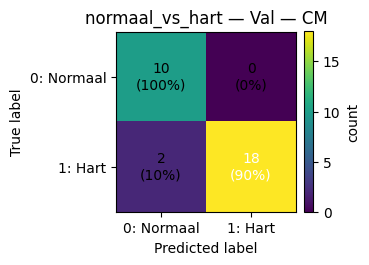

normaal_vs_hart — Test — Accuracy: 0.844
Label mapping: 0 = 'Normaal', 1 = 'Hart'


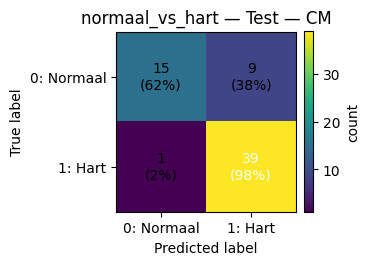

INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpj516ax_r\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpj516ax_r\assets


Saved: C:\Users\MSI\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\experiments\models\cnn_normaal_vs_hart.tflite


In [ ]:
# 1) Hart vs Normaal
model_hn, stats_hn = run_experiment("Hart", "Normaal", "hart_vs_normaal")
print(stats_hn)


=== Experiment: Normaal vs Hoest ===
Aantal segmenten: 169 | {'Normaal': 115, 'Hoest': 54}
[balanced] y-train {0: 94, 1: 27} | y-val {1: 11, 0: 3} | y-test {0: 18, 1: 16}
Shapes: 
  train: (121, 513, 182, 1) 
  val  : (14, 513, 182, 1) 
  test : (34, 513, 182, 1)
Epoch 1/40
4/4 - 3s - loss: 10.3101 - accuracy: 0.7851 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010 - 3s/epoch - 745ms/step
Epoch 2/40
4/4 - 3s - loss: 0.9081 - accuracy: 0.9587 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010 - 3s/epoch - 627ms/step
Epoch 3/40
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010 - 2s/epoch - 624ms/step
Epoch 4/40
4/4 - 3s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010 - 3s/epoch - 637ms/step
Epoch 5/40

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.00

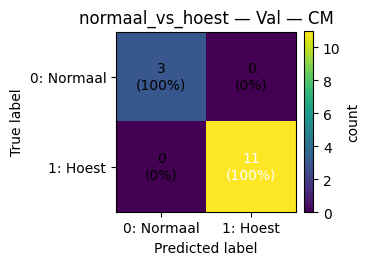

normaal_vs_hoest — Test — Accuracy: 1.000
Label mapping: 0 = 'Normaal', 1 = 'Hoest'


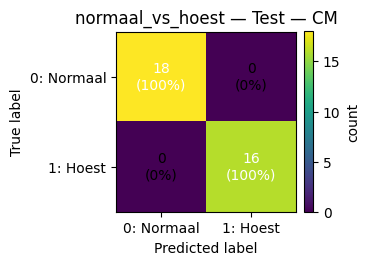

INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmp52j7l176\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmp52j7l176\assets


Saved: C:\Users\MSI\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\experiments\models\cnn_normaal_vs_hoest.tflite


In [ ]:
# 2) Normaal vs Hoest
model_hh, stats_hh = run_experiment("Hart", "Hoest",   "hart_vs_hoest")
print(stats_hh)


=== Experiment: Hoest vs Hart ===
Aantal segmenten: 254 | {'Hart': 200, 'Hoest': 54}
[balanced] y-train {1: 140, 0: 37} | y-val {1: 20, 0: 5} | y-test {1: 40, 0: 12}
Shapes: 
  train: (177, 513, 182, 1) 
  val  : (25, 513, 182, 1) 
  test : (52, 513, 182, 1)
Epoch 1/40
6/6 - 5s - loss: 11.0194 - accuracy: 0.6441 - val_loss: 33.2716 - val_accuracy: 0.2000 - lr: 0.0010 - 5s/epoch - 782ms/step
Epoch 2/40
6/6 - 4s - loss: 4.7710 - accuracy: 0.6893 - val_loss: 1.9494 - val_accuracy: 0.8000 - lr: 0.0010 - 4s/epoch - 672ms/step
Epoch 3/40
6/6 - 4s - loss: 1.2290 - accuracy: 0.8249 - val_loss: 1.2987 - val_accuracy: 0.4400 - lr: 0.0010 - 4s/epoch - 701ms/step
Epoch 4/40
6/6 - 4s - loss: 0.3288 - accuracy: 0.8305 - val_loss: 0.8732 - val_accuracy: 0.8800 - lr: 0.0010 - 4s/epoch - 722ms/step
Epoch 5/40
6/6 - 4s - loss: 0.1613 - accuracy: 0.9661 - val_loss: 0.7875 - val_accuracy: 0.9200 - lr: 0.0010 - 4s/epoch - 674ms/step
Epoch 6/40
6/6 - 4s - loss: 0.1087 - accuracy: 0.9492 - val_loss: 0.7210 

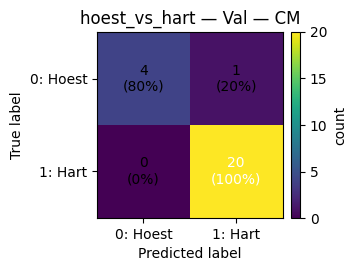

hoest_vs_hart — Test — Accuracy: 0.981
Label mapping: 0 = 'Hoest', 1 = 'Hart'


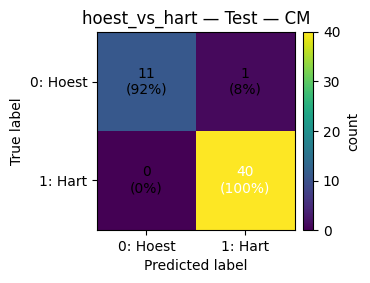

INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmphcrfb0q1\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmphcrfb0q1\assets


Saved: C:\Users\MSI\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\experiments\models\cnn_hoest_vs_hart.tflite


In [ ]:
# 3) Hoest vs Hart
model_hn2, stats_hn2= run_experiment("Hoest","Normaal","hoest_vs_normaal")
print(stats_hn2)